# Sistem Rekomendasi Musik Spotify
**Oleh : Yoga Mileniandi**

## Pendahuluan
![spotify](https://user-images.githubusercontent.com/61934759/137764151-d27729b5-7145-4df8-97e2-168e7bbb0caf.png)
Proyek berupa sistem rekomendasi musik yang ditunjukkan bagi pengguna aplikasi Spotify. Sistem rekomendasi musik ini menggunakan pendekatan content-based filtering. Content-based filtering melakukan rekomendasi dengan mempelajari profil minat pengguna baru berdasarkan data dari objek yang telah dinilai pengguna.


## 1. Mempersiapkan Library dan Dataset

### 1.1 Memanggil Library

In [1]:
# Library untuk pengolahan data
import numpy as np
import pandas as pd
from zipfile import ZipFile
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer

# Library untuk visualisasi data
import matplotlib.pyplot as plt
import seaborn as sns

# Library untuk pemodelan
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import calinski_harabasz_score

### 1.2 Mengunduh Dataset from Kaggle

In [2]:
# Melakukan pengaturan API Kaggle
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
# Mengambil dataset dari Kaggle
!kaggle datasets download -d edalrami/19000-spotify-songs

  0% 0.00/1.18M [00:00<?, ?B/s]
100% 1.18M/1.18M [00:00<00:00, 19.5MB/s]


### 1.3 Memuat dataset

In [4]:
# Ekstrasi data
path = '/content/19000-spotify-songs.zip'
with ZipFile(path, 'r') as zip_ref:
  zip_ref.extractall('working')

In [30]:
# Memuat dataset dengan library pandas
song_info = pd.read_csv("/content/working/song_info.csv")

## 2. Pemahaman Data

Data yang digunakan untuk proyek kali ini adalah 19,000 Spotify Song yang diunduh dari [Dataset Kaggle](https://www.kaggle.com/edalrami/19000-spotify-songs/code). Dataset tersebut memiliki dua buah file berformat csv, yaitu _song_data.csv_ dan _song_info.csv_. _song_data.csv_ berisi informasi yang berkaitan tentang atribut audio lagu. Sedangkan _song_info.csv_ berisi informasi yang berkaitan tentang metadata lagu.

In [6]:
# Melihat isi song_info
song_info.head()

,song_name,artist_name,album_names,playlist
0,Boulevard of Broken Dreams,Green Day,Greatest Hits: God's Favorite Band,00s Rock Anthems
1,In The End,Linkin Park,Hybrid Theory,00s Rock Anthems
2,Seven Nation Army,The White Stripes,Elephant,00s Rock Anthems
3,By The Way,Red Hot Chili Peppers,By The Way (Deluxe Version),00s Rock Anthems
4,How You Remind Me,Nickelback,Silver Side Up,00s Rock Anthems


In [7]:
song_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18835 entries, 0 to 18834
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   song_name    18835 non-null  object
 1   artist_name  18835 non-null  object
 2   album_names  18835 non-null  object
 3   playlist     18835 non-null  object
dtypes: object(4)
memory usage: 588.7+ KB


Untuk penjelasan tentang variabel-variabel kolom tersebut, dapat dilihat pada poin-poin berikut :
* `song_name` : Judul lagu yang tertampil
* `artist_name` : Nama penyanyi yang menyanyikan lagu tersebut
* `album_names` : Nama album dimana lagu tersebut termasuk sebagai koleksinya, album sendiri adalah koleksi lagu dari suatu penyanyi
* `playlist` : Kumpulan lagu yang memiliki suatu kesamaan

## 3. Eksplorasi Data
Kemudian dilakukan juga eksplorasi data dan visualisasi tentang kolomnya.

In [8]:
# Melihat jumlah lagu yang ada pada dataset
print("Jumlah lagu yang ada dalam dataset : ", len(song_info.song_name.unique()))

Jumlah lagu yang ada dalam dataset :  13070


In [9]:
# Melihat jumlah artis yang ada pada dataset
print("Jumlah Penyanyi dalam dataset : ", len(song_info.artist_name.unique()))

Jumlah Penyanyi dalam dataset :  7564


In [10]:
# Melihat jumlah album dalam dataset
print("Jumlah Album dalam dataset : ", len(song_info.album_names.unique()))

Jumlah Album dalam dataset :  12014


In [11]:
# Melihat jumlah playlist dalam dataset
print("Jumlah Playlist dalam dataset : ", len(song_info.playlist.unique()))

Jumlah Playlist dalam dataset :  300


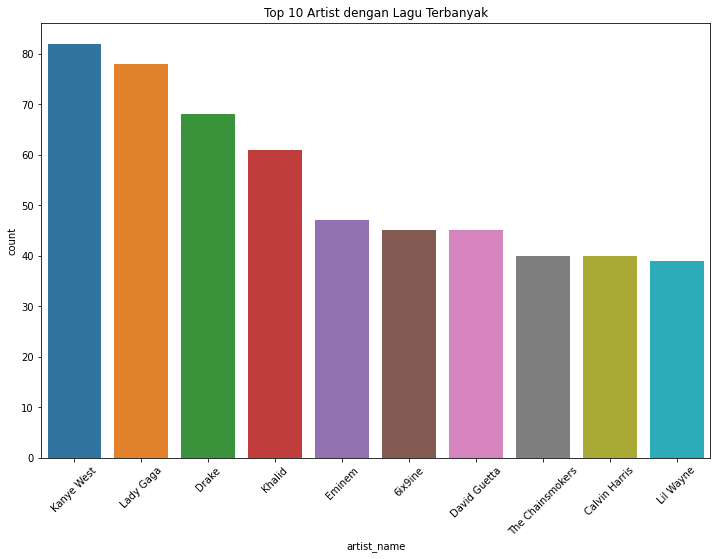

In [12]:
# To 10 Penyayi dengan lagu terbanyak
plt.figure(figsize=(12,8))
sns.countplot(x='artist_name', data = song_info, order = song_info.artist_name.value_counts().sort_values(ascending=False).iloc[:10].index)
plt.title("Top 10 Artist dengan Lagu Terbanyak")
plt.xticks(rotation = 45)
plt.show()

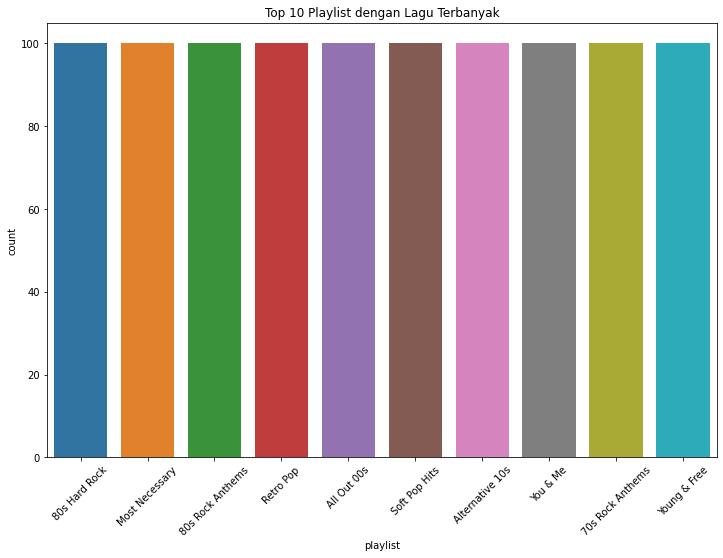

In [13]:
# Top 10 playlist dengan lagu terbanyak
plt.figure(figsize=(12,8))
sns.countplot(x='playlist', data=song_info, order = song_info.playlist.value_counts().sort_values(ascending=False).iloc[:10].index)
plt.title("Top 10 Playlist dengan Lagu Terbanyak")
plt.xticks(rotation = 45)
plt.show()

In [14]:
# Melihat adanya missing value
song_info.isna().sum()

song_name      0
artist_name    0
album_names    0
playlist       0
dtype: int64

## 4. Data Preparation
Tahap berikutnya adalah _data preparation_, tahap dimana data akan diolah sehingga sudah siap untuk proses pemodelan.

In [31]:
# Membuang data duplikat duplikat
song_info = song_info.drop_duplicates(['song_name', 'artist_name'])
song_info

,song_name,artist_name,album_names,playlist
0,Boulevard of Broken Dreams,Green Day,Greatest Hits: God's Favorite Band,00s Rock Anthems
1,In The End,Linkin Park,Hybrid Theory,00s Rock Anthems
2,Seven Nation Army,The White Stripes,Elephant,00s Rock Anthems
3,By The Way,Red Hot Chili Peppers,By The Way (Deluxe Version),00s Rock Anthems
4,How You Remind Me,Nickelback,Silver Side Up,00s Rock Anthems
...,...,...,...,...
18830,Let It Breathe,Water Liars,Water Liars,Your Favorite Coffeehouse
18831,Answers,Brooke Annibale,The Simple Fear,Your Favorite Coffeehouse
18832,Sudden Love (Acoustic),The Woodlands,"Parallels, Vol. II",Your Favorite Coffeehouse
18833,Gentle on My Mind,Robert Ellis,Dear John,Your Favorite Coffeehouse


Membuang data duplikasi yang memiliki kesamaan pada kolom `song_name` dan  `artist_name`. Tujuannya supaya tidak muncul suatu data sebanyak 2 kali pada proses rekomendasi nanti. Proses penghilangan data duplikasi ini adalah dengan perintah _drop_duplicates_ dari library pandas.

In [32]:
# Menggabungkan kolom artist_name, album_names, dan playlist
new_song_info = song_info.copy()
new_song_info['info'] = new_song_info[['artist_name','album_names','playlist']].agg(' '.join, axis=1) 

# Melakukan drop pada kolom artist_name, album_names, dan playlist
new_song_info = new_song_info.drop(columns=['artist_name', 'album_names', 'playlist'], axis = 1)
new_song_info.head()


,song_name,info
0,Boulevard of Broken Dreams,Green Day Greatest Hits: God's Favorite Band 0...
1,In The End,Linkin Park Hybrid Theory 00s Rock Anthems
2,Seven Nation Army,The White Stripes Elephant 00s Rock Anthems
3,By The Way,Red Hot Chili Peppers By The Way (Deluxe Versi...
4,How You Remind Me,Nickelback Silver Side Up 00s Rock Anthems


Membuat fitur baru bernama `info` dengan cara menggabungkan kolom `artist_name`, `album_names`, dan `playlist`. Hal tersebut dilakukan untuk memudahkan proses TF-IDF, karena fitur `info` telah mencakup ketiga fitur kolom.

## 5. Pemodelan dan Hasil
Setelah data telah diolah, maka proses selanjutnya adalah pemodelan. Dalam pemodelan ini data akan dilakukan proses TF-IDF dan cosine similarity

### TF-IDF
Secara sederhana TF merupakan frekuensi kemunculan kata dalam suatu dokumen. IDF merupakan sebuah perhitungan dari bagaimana kata didistribusikan secara luas pada koleksi dokumen yang bersangkutan. Pada projek ini TF-IDF digunakan pada sistem rekomendasi untuk menemukan representasi fitur penting dari setiap kategori masakan. Untuk melakukan proses TF-IDF ini digunakan fungsi _TfidfVectorizer_ dari sklearn.

In [33]:
# Persiapan tfidfvectorizer
tf = TfidfVectorizer()

# Melakukan perhitungan idf pada kolom info
tf.fit(new_song_info['info'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [34]:
# Mapping array dari fitur index integer ke fitur nama
tf.get_feature_names()

['000',
 '001',
 '00s',
 '01',
 '03',
 '05',
 '07',
 '070',
 '079me',
 '10',
 '100',
 '1000',
 '1000hp',
 '1001',
 '100k',
 '100x',
 '101',
 '104',
 '105',
 '10cc',
 '10s',
 '10th',
 '11',
 '112',
 '112th',
 '11th',
 '12',
 '1234',
 '13',
 '130',
 '13alloonz',
 '13lack',
 '13th',
 '14',
 '140',
 '1435',
 '145',
 '1472',
 '15',
 '150',
 '151',
 '155',
 '15th',
 '16',
 '160',
 '165',
 '167',
 '17',
 '175',
 '18',
 '180',
 '182',
 '187um',
 '19',
 '1919',
 '1931',
 '1942',
 '1945',
 '1948',
 '1949',
 '1950',
 '1950s',
 '1951',
 '1952',
 '1953',
 '1954',
 '1955',
 '1956',
 '1957',
 '1959',
 '1960',
 '1961',
 '1962',
 '1963',
 '1964',
 '1965',
 '1966',
 '1967',
 '1968',
 '1969',
 '1970',
 '1971',
 '1972',
 '1973',
 '1974',
 '1975',
 '1976',
 '1977',
 '1979',
 '1980',
 '1982',
 '1983',
 '1984',
 '1986',
 '1987',
 '1989',
 '1990',
 '1991',
 '1992',
 '1993',
 '1994',
 '1995',
 '1996',
 '1997',
 '1998',
 '1999',
 '19xx',
 '1s',
 '1st',
 '1take',
 '1takejay',
 '20',
 '200',
 '2000',
 '20000',
 '

In [35]:
# Melakukan fit lagu di translasikan ke bentuk matriks
tfidf_matrix = tf.fit_transform(new_song_info['info'])

# Melihat ukuran matriks
tfidf_matrix.shape

(14006, 14910)

In [36]:
tfidf_matrix.todense()

matrix([[0.        , 0.        , 0.29884413, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.28278453, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.324561  , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

### Cosine Similarity
_Cosine similarity_ adalah metrik yang digunakan untuk mengukur tingkat kesamaan suatu dokumen terlepas dari ukurannya. Dan secara matematis, _cosine similarity_ mengukur kosinus sudut antara dua vektor yang diproyeksikan dalam ruang multidimensi. _Cosine similarity_ memiliki keuntungan apabila dua dokumen serupa terpisah oleh _euclidean distance_ karena ukuran dokumen, kemungkinan mereka masih berorientasi ada. Dalam proses ini _cosine similarity_ dipanggil dengan fungsi _cosine_similarity_ dari sklearn. Input fungsi _cosine_similarity_ adalah matrix hasil dari proses TF-IDF, yang kemudian menghasilkan output berupa array tingkat kesamaan.

In [37]:
# Menghitung cosine similarity
cos_sim = cosine_similarity(tfidf_matrix)
cos_sim

array([[1.        , 0.18658838, 0.21415355, ..., 0.11746349, 0.11831717,
        0.11710081],
       [0.18658838, 1.        , 0.20264514, ..., 0.        , 0.        ,
        0.        ],
       [0.21415355, 0.20264514, 1.        , ..., 0.01742547, 0.        ,
        0.        ],
       ...,
       [0.11746349, 0.        , 0.01742547, ..., 1.        , 0.27943212,
        0.27655941],
       [0.11831717, 0.        , 0.        , ..., 0.27943212, 1.        ,
        0.27856936],
       [0.11710081, 0.        , 0.        , ..., 0.27655941, 0.27856936,
        1.        ]])

In [38]:
# Membuat dataframe dari variabel cos_sim dengan baris dan kolom berupa song_name
cos_sim_df = pd.DataFrame(cos_sim, index=new_song_info['song_name'], columns=new_song_info['song_name'])
print('Shape:', cos_sim_df.shape)

Shape: (14006, 14006)


### Fungsi Rekomendasi
ungsi tersebut digunakan untuk memberikan rekomendasi berdasarkan sebuah nama lagu. Pada fungsi tersebut akan dilakukan pencarian kolom  yang sama dengan nama lagu yang dimasukkan pada dataframe hasil _cosine similarity_. Setelah itu diurutkan berdasarkan nilai _cosine similarity_ tertinggi, kemudian dilakukan _drop_ nama lagu yang dijadikan acuan agar tidak muncul dalam daftar rekomendasi. Kemudian outputnya berupa 5 lagu yang memiliki cosine similarity tertinggi.

In [49]:
def song_recommendations(song_name, similarity_data=cos_sim_df, items=song_info, k=5): 
  print(f"Jika kamu menyukai lagu {song_name}, mungkin kamu juga menyukai 5 lagu berikut :")
  # Mengambil data dengan menggunakan argpartition untuk melakukan partisi secara tidak langsung sepanjang sumbu yang diberikan    
  index = similarity_data.loc[:,song_name].to_numpy().argpartition(range(-1, -k, -1))
    
  # Mengambil data dengan similarity terbaik
  closest = similarity_data.columns[index[-1:-(k+2):-1]]
    
  # Drop song_name
  closest = closest.drop(song_name, errors='ignore')
 
  return pd.DataFrame(closest).merge(items).head(k)

In [50]:
# Melihat informasi tentang lagu yang akan dijadikan acua
song_info[song_info.song_name.eq('Rap God')]

,song_name,artist_name,album_names,playlist
3710,Rap God,Eminem,The Marshall Mathers LP2 (Deluxe),Big Gains Workout


In [51]:
# Mendapatkan rekomendasi musik
song_recommendations(song_name="Rap God")

Jika kamu menyukai lagu Rap God, mungkin kamu juga menyukai 5 lagu berikut :


,song_name,artist_name,album_names,playlist
0,Love Game,Eminem,The Marshall Mathers LP2 (Deluxe),Clinically Cold
1,Rhyme Or Reason,Eminem,The Marshall Mathers LP2 (Deluxe),Ill Lyricist
2,The Way I Am,Charlie Puth,Voicenotes,A Perfect Day
3,The Way I Am,Eminem,The Marshall Mathers LP,Gold School
4,Cinderella Man,Eminem,Recovery,Big Gains Workout


## 6. Evaluasi

Metriks yang akan digunakan untuk evaluasi pada sistem rekomendasi ini adalah presisi. Presisi merupakan banyaknya item rekomendasi yang relevan dibagi dengan banyaknya item yang direkomendasikan. Rumus dari metriks presisi adalah sebagai berikut
![presisi](https://user-images.githubusercontent.com/61934759/138005224-8c8be6fd-58d8-4bc6-978f-d7ee5ce9c3e8.JPG)


In [54]:
# Presisi sistem rekomendasi
relevan = 4 # Banyaknya item rekomendasi yang relevan
rekomen = 5 # Banyaknya item yang direkomendasikan
presisi = relevan / rekomen
print(f"Jadi Presisi rekomendasi yang diberikan untuk lagu 'Rap God' adalah {presisi*100}%")

Jadi Presisi rekomendasi yang diberikan untuk lagu 'Rap God' adalah 80.0%


## Referensi

* https://towardsdatascience.com/recommendation-systems-models-and-evaluation-84944a84fb8e
* https://www.kaggle.com/benroshan/content-collaborative-anime-recommendation#Recommendation-building-phase---Tsukuru-(%E4%BD%9C%E3%82%8B)